# Regularized linear regression and bias vs variance

## 1 Regularized Linear Regression

"...you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir."

### 1.1 Visualizing the dataset

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# Load training data
data = scipy.io.loadmat('data/ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
# training data X, y
X = data['X']
y = data['y']

In [4]:
X.shape

(12, 1)

In [5]:
# cross-validation data Xval, yval
Xval = data['Xval']
yval = data['yval']

In [6]:
Xval.shape

(21, 1)

In [7]:
# test data Xtest, ytest
Xtest = data['Xtest']
ytest = data['ytest']

In [8]:
Xtest.shape

(21, 1)

In [9]:
m = X.shape[0] # number of training examples

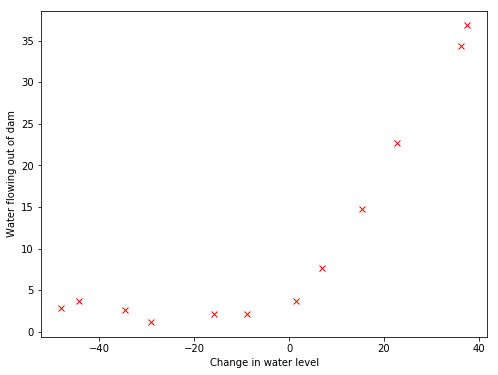

In [10]:
# Plot training data
plt.figure(figsize=(8,6))
plt.plot(X, y, 'rx')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.show()

### 1.2 Regularized linear regression cost function

In [11]:
def linear_reg_cost_function(X, y, theta, Lambda):
    '''
    Computes the cost of using theta as the parameter for linear regression to fit
    the data points in X and y, with regularisation constant Lambda.
    Returns the cost in J and the gradient in grad.
    '''

    # undo the fact that scipy.minimize needs flat gradient output
    # (see comments by grad = np.ndarray.flatten(grad))
    theta = np.reshape(theta, (X.shape[1], 1))

    
    ## Cost
    J = 0
    grad = np.zeros(theta.shape)
    
    m = len(y) # number of examples
    
    J = 1/(2*m) * np.sum((np.dot(X, theta) - y)**2) + Lambda/(2*m) * np.sum(theta[1:]**2)
        

    ## Gradient
    grad[0] = 1/m * np.dot((np.dot(X, theta) - y).T, X)[:,0]
    grad[1:] = (1/m * np.dot((np.dot(X, theta) - y).T, X)[:,1:] + Lambda/m * theta[1:].T).T
       
    # scipy.minimize requires a flat gradient output,
    # see https://stackoverflow.com/q/8752169/8291169
    grad = np.ndarray.flatten(grad)
    
    return J, grad

In [12]:
theta = np.array([[1],[1]]) # lots of square brackets to enforce shape = (2,1)
# Add a column of ones to X for bias
J = linear_reg_cost_function(np.column_stack((np.ones(m), X)), y, theta, 1)[0]

In [13]:
print('Cost at theta = [1, 1]:', J)
print('Expected cost: 303.993192')

Cost at theta = [1, 1]: 303.99319222
Expected cost: 303.993192


### 1.3 Regularized linear regression gradient

In [14]:
# Gradient calculation implemented in linear_reg_cost_function()

In [15]:
J, grad = linear_reg_cost_function(np.column_stack((np.ones(m), X)), y, theta, 1)

In [16]:
print('Gradient at theta = [1, 1]:\n', grad)
print('\nExpected gradient:\n[-15.303016, 598.250744]')

Gradient at theta = [1, 1]:
 [ -15.30301567  598.25074417]

Expected gradient:
[-15.303016, 598.250744]


### 1.4 Fitting linear regression

In [17]:
def train_linear_reg(X, y, Lambda):
    '''
    Trains linear regression using dataset (X, y) and regularization parameter Lambda.
    Returns the trained parameters theta.
    '''
    
    theta = np.zeros((X.shape[1], 1))

    def cost_func(t):
        return linear_reg_cost_function(X, y, t, Lambda)
    
    res = minimize(fun=cost_func, x0=theta, method='CG', jac=True, options={'maxiter':200})
    theta = res.x
    
    return theta

In [18]:
# Train linear regression with Lambda = 0
# We expect a very poor fit because we're trying to fit non-linear data with a straight line

Lambda = 0
theta = train_linear_reg(np.column_stack((np.ones(m), X)), y, Lambda)
theta

array([ 13.08790351,   0.36777923])

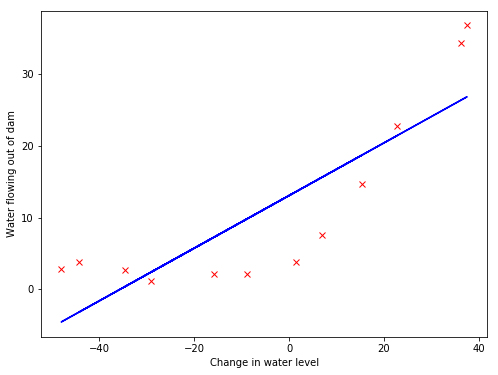

In [19]:
# Plot data and fit
plt.figure(figsize=(8,6))
plt.plot(X, y, 'rx')
plt.plot(X, np.dot(np.column_stack((np.ones(m), X)), theta), 'b-')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.show()

# As expected, a very poor fit because we're trying to fit non-linear data with a straight line

## 2 Bias-variance

### 2.1 Learning curves

In [20]:
def learning_curve(X, y, Xval, yval, Lambda):
    
    '''
    Returns the training and cross validation set errors
    for a learning curve in two vectors of the same length
    - error_train and error_val. error_train(i) contains
    the training error for i examples (and similarly for error_val(i)).
    '''
    
    m = X.shape[0] # number of training examples
    m_val = Xval.shape[0] # number of validation examples
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    # Compute for different sizes of training set
    for i in range(m):
        # Train using i training examples
        theta = train_linear_reg(X[:i+1], y[:i+1], Lambda)
        
        # Calculate error_train for i training examples
        # (just comptue cost with Lambda=0)
        error_train[i] = linear_reg_cost_function(X[:i+1], y[:i+1], theta, 0)[0]
        
        # Calculate error_val using all validation examples
        # (just comptue cost with Lambda=0)
        error_val[i] = linear_reg_cost_function(Xval, yval, theta, 0)[0]
        
    return error_train, error_val

In [21]:
Lambda = 0
m_val = Xval.shape[0] # number of validation examples

error_train, error_val = learning_curve(np.column_stack((np.ones(m), X)), y, 
                                        np.column_stack((np.ones(m_val), Xval)), yval,
                                        Lambda)

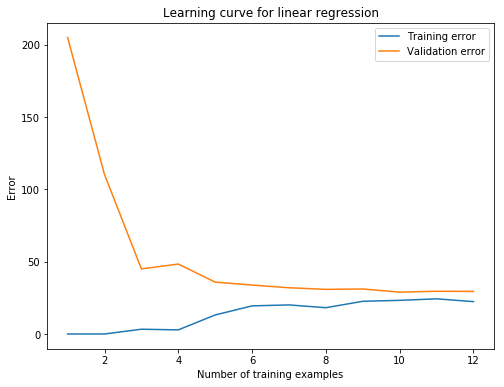

In [22]:
plt.figure(figsize=(8,6))
plt.plot(range(1, m+1), error_train)
plt.plot(range(1, m+1), error_val)
plt.legend(['Training error', 'Validation error'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.show()

# Since the model is underfitting the data, we expect to see a graph with high bias,
# i.e. both training error and cross-validation error are high even with many
# training examples - adding more training data does not help.

## 3 Polynomial regression

"The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features."

In [23]:
def poly_features(X, p):
    '''
    Takes a data matrix X (size m x 1) and
    maps each example into its polynomial features where
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p]
    '''
    
    X_poly = np.zeros((X.size, p))
    
    for i in range(p):
        X_poly[:, i] = X[:,0]**(i+1)
        # Need to specify 0th column otherwise we get a shape mismatch...
    
    return X_poly

In [24]:
def feature_normalise(X):
    '''
    Returns a normalized version of X where the mean value
    of each feature (column) is 0 and the standard deviation is 1.
    '''
    
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

In [25]:
p = 8 # order of polynomial features

In [26]:
# Map X onto polynomial features and normalize
X_poly = poly_features(X, p)
X_poly, mu, sigma = feature_normalise(X_poly) # Normalize
X_poly = np.column_stack((np.ones(m), X_poly)) # Add bias column

# Map X_poly_test and normalize using mu and sigma from training data X
X_poly_test = poly_features(Xtest, p)
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test / sigma
m_test = Xtest.shape[0]
X_poly_test = np.column_stack((np.ones(m_test), X_poly_test)) # Add bias column

# Map X_poly_val and normalize using mu and sigma from training data X
X_poly_val = poly_features(Xval, p)
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val / sigma
m_val = Xval.shape[0]
X_poly_val = np.column_stack((np.ones(m_val), X_poly_val)) # Add bias column

print('Normalized Training Example 1:')
print(X_poly[1,:])

Normalized Training Example 1:
[ 1.         -0.8389201   0.0013142  -0.25896174 -0.34156482  0.09754927
 -0.45519664  0.26677343 -0.46887381]


### 3.1 Learning Polynomial Regression

In [27]:
Lambda = 0
theta = train_linear_reg(X_poly, y, Lambda)

In [28]:
def plot_fit(min_x, max_x, mu, sigma, theta, p):
    
    x = np.arange(min_x-10, max_x+10, 0.05)
    m = x.shape[0]
    x = np.reshape(x, (m,1))
    
    x_poly = poly_features(x, p)
    x_poly = x_poly - mu
    x_poly = x_poly / sigma
    x_poly = np.column_stack((np.ones(m), x_poly))
    plt.plot(x, np.dot(x_poly, theta), '--')

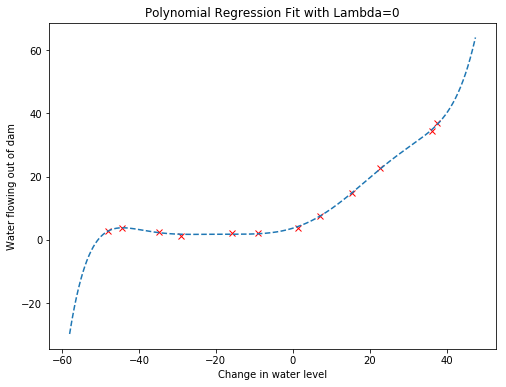

In [29]:
plt.figure(figsize=(8,6))
plt.plot(X, y, 'rx')
plot_fit(min(X), max(X), mu, sigma, theta, p)
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.title('Polynomial Regression Fit with Lambda=0')
plt.show()

# We expect to see an overfit to the training data (i.e. high variance)
# because we're using Lambda=0 (i.e. no regularisation) and high-order
# polynomial features.